In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba as nb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numbalsoda import lsoda_sig, lsoda
from numba import types
import os

# Using seaborn's style
plt.style.use('ggplot')
width = 'thesis'

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    # Remove grid lines
    "axes.grid": False,
    # Show the ticks for the x and y axes
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "xtick.major.size" : 6,
    "ytick.major.size" : 6, 
    "xtick.minor.size" : 3, 
    "ytick.minor.size" : 3,
    "xtick.major.width" : 1,
    "ytick.major.width" : 1,
    "xtick.minor.width" : 1,
    "ytick.minor.width" : 1,
    # Outline the plot area
    "axes.spines.top": False,
    "axes.spines.right": False,
}

plt.rcParams.update(tex_fonts)

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [7]:
# Load the connected.csv file
df = pd.read_csv('connected.csv', index_col=0)
df2 = pd.read_csv('connected2.csv', index_col=0)
df3 = pd.read_csv('connected3.csv', index_col=0)
df4 = pd.read_csv('connected4.csv', index_col=0)
df5 = pd.read_csv('connected5.csv', index_col=0)

# Create a list of the different dataframes
dfs = [df, df2, df3, df4, df5]

In [10]:
dfs

[      Points In Region
                       
 1                  325
 2                  229
 3                    2
 4                    1
 5                   49
 ...                ...
 1078                 1
 1079                 4
 1080                 1
 1081                 2
 1082                 1
 
 [1082 rows x 1 columns],
      Points In Region
                      
 1                   3
 2                   1
 3                 397
 4                3208
 5                   5
 ..                ...
 873                 2
 874                 1
 875                 1
 876                 1
 877                 2
 
 [877 rows x 1 columns],
      Points In Region
                      
 1                  26
 2                 244
 3                  20
 4                   1
 5                  86
 ..                ...
 944                 1
 945                 1
 946                 1
 947                 1
 948                 1
 
 [948 rows x 1 columns],
      Po

In [13]:
# For each dataframe, sort the values from lowest to highest, then calculate the frequency (from 0 to 1) of each unique number and save it to a new dataframe
freq_dfs = []
for df in dfs:
    df = df.sort_values(by='Points In Region')
    df = df['Points In Region'].value_counts(normalize=True)
    df = df.reset_index()
    df = df.rename(columns={'index': 'Points In Region', 'Points In Region': 'Frequency'})
    freq_dfs.append(df)

In [16]:
freq_dfs

[    Frequency  proportion
 0           1    0.585952
 1           2    0.102588
 2           3    0.054529
 3           4    0.031423
 4           7    0.022181
 ..        ...         ...
 91        109    0.000924
 92        119    0.000924
 93        120    0.000924
 94        130    0.000924
 95       2606    0.000924
 
 [96 rows x 2 columns],
     Frequency  proportion
 0           1    0.583808
 1           2    0.099202
 2           3    0.055872
 3           4    0.036488
 4           5    0.021665
 ..        ...         ...
 75         88    0.001140
 76         98    0.001140
 77        112    0.001140
 78        113    0.001140
 79       4008    0.001140
 
 [80 rows x 2 columns],
     Frequency  proportion
 0           1    0.577004
 1           2    0.097046
 2           3    0.058017
 3           4    0.040084
 4           5    0.026371
 ..        ...         ...
 94        103    0.001055
 95        105    0.001055
 96        112    0.001055
 97        113    0.001055
 98

In [58]:
# Load the connected_Y_FIT.csv file (we have to transpose it because it is a single row)
df_fit = pd.read_csv('connected_Y_FIT_1.csv')
df2_fit = pd.read_csv('connected_Y_FIT_2.csv')
df3_fit = pd.read_csv('connected_Y_FIT_3.csv')
df4_fit = pd.read_csv('connected_Y_FIT_4.csv')
df5_fit = pd.read_csv('connected_Y_FIT_5.csv')

# Create a list of the different dataframes
dfs_fit = [df_fit, df2_fit, df3_fit, df4_fit, df5_fit]

In [64]:
# For each dataframe, get the names of the columns, convert them to floats and save them to a new dataframe
fit_dfs = []
for df in dfs_fit:
    df = df.columns.values
    df = df.astype(float)
    fit_dfs.append(df)
    

In [67]:
# Take the mean of the different dataframes, but consider that they have different shapes, so we have to pad them with NaNs
fit_dfs = pd.DataFrame(fit_dfs).T
fit_dfs = fit_dfs.fillna(method='ffill')
fit_dfs = fit_dfs.fillna(method='bfill')
fit_dfs = fit_dfs.mean(axis=1)

C:\Users\adara\AppData\Local\Temp\ipykernel_25996\3572510086.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fit_dfs = fit_dfs.fillna(method='ffill')
C:\Users\adara\AppData\Local\Temp\ipykernel_25996\3572510086.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fit_dfs = fit_dfs.fillna(method='bfill')


In [69]:
fit_dfs.values

array([0.59559   , 0.157718  , 0.0725058 , 0.041777  , 0.0272418 ,
       0.0192094 , 0.014297  , 0.0110694 , 0.00883348, 0.0072189 ,
       0.00601414, 0.00509076, 0.0043671 , 0.00378914, 0.00332004,
       0.00293398, 0.00261234, 0.00234142, 0.00211108, 0.00191354,
       0.00174282, 0.00159426, 0.00146414, 0.00134954, 0.00124806,
       0.00115774, 0.00110716, 0.00107684, 0.00106321, 0.00105087])

In [70]:
x_data_estimate = fit_dfs.values**(-(1/1.91))

In [72]:
np.log10(x_data_estimate)

array([0.11782859, 0.41995745, 0.59666348, 0.72202238, 0.81924827,
       0.89868387, 0.96584036, 1.02401881, 1.07532365, 1.12121936,
       1.16273637, 1.20063737, 1.23550098, 1.26777976, 1.29783072,
       1.32593867, 1.35234047, 1.37723596, 1.40078288, 1.4231217 ,
       1.4443704 , 1.46462872, 1.48398816, 1.50252054, 1.52029557,
       1.53737642, 1.54753383, 1.55384755, 1.55674438, 1.5593993 ])

In [73]:
def powerlaw(x, amp, index):
    return amp * (x**index)

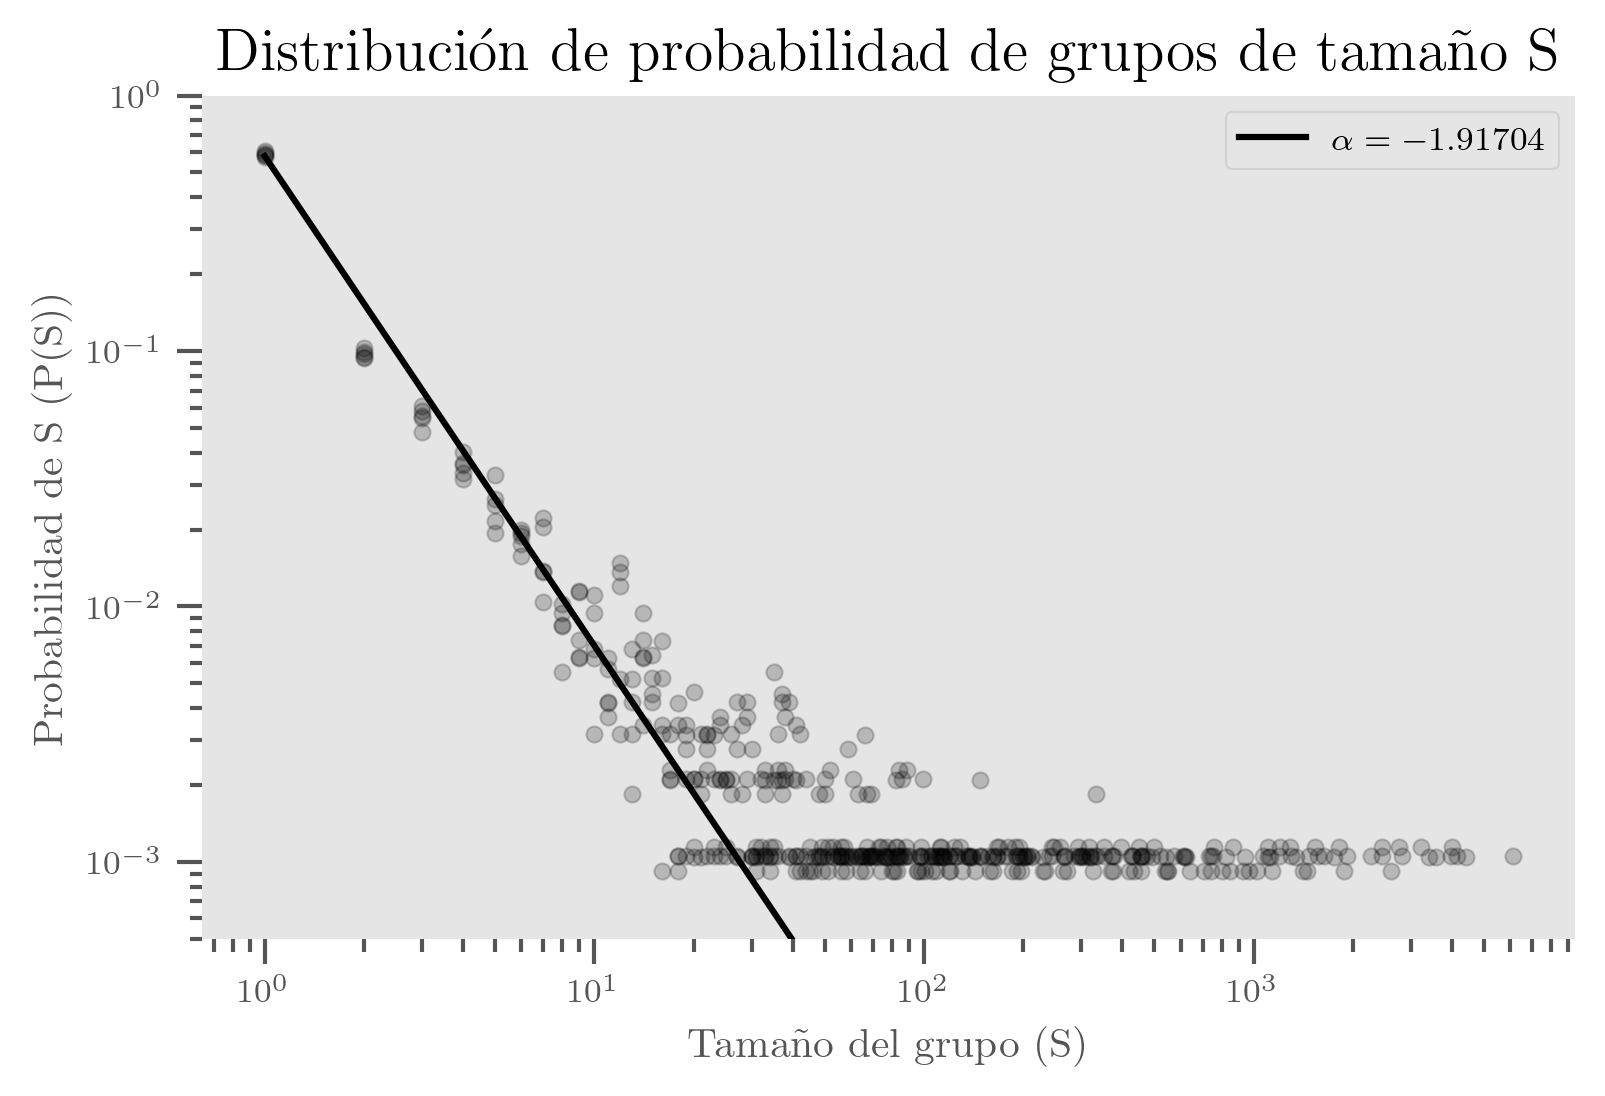

In [93]:
# Now for each dataframe in freq_dfs, we have to plot the frequency of each unique number
# We will use the same plot for this
fig, ax = plt.subplots(figsize=set_size(width, fraction=1), dpi=300)
for df in freq_dfs:
    ax.scatter(df['Frequency'], df['proportion'], c="k", s=15, alpha=0.20)
# Plot a powerlaw using an exponent of -1.91704
x = np.linspace(1e0, 1e3, 1000)
y = powerlaw(x, 0.58, -1.91704)
ax.plot(x, y, c='k', label=r'$\alpha = -1.91704$', linewidth=1.5)
ax.legend()
ax.set_xlabel('Tamaño del grupo (S)')
ax.set_ylabel('Probabilidad de S (P(S))')
ax.set_title('Distribución de probabilidad de grupos de tamaño S')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(5e-4, 1e0)
# Save the figure
plt.savefig('POWERLAW_THESIS.pdf', bbox_inches='tight')